<a id='content'></a>

In case of rendering issues, please use nbviewer: https://nbviewer.jupyter.org/

<h1 align="center">City Explorer - Munich</h1>

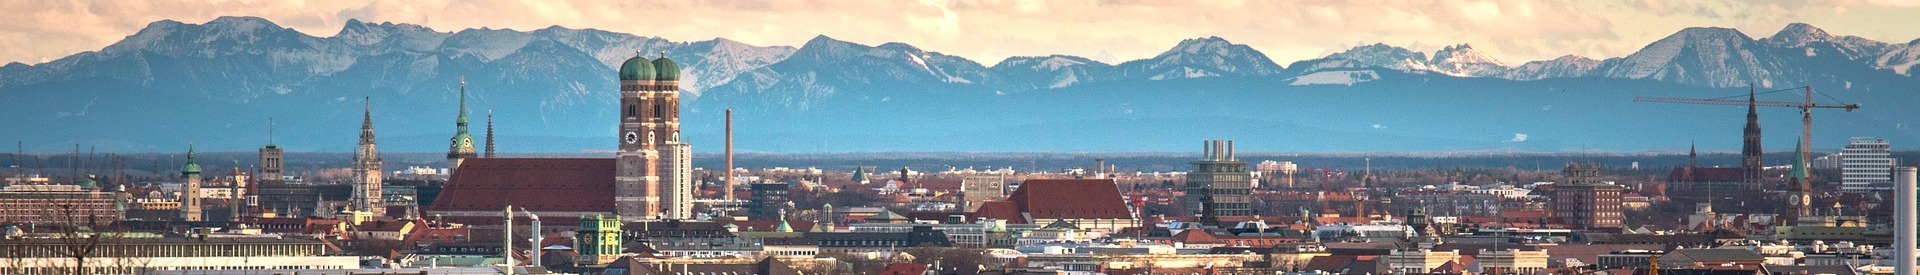

When visiting a new city, many people wish to stroll around to explore the shops, cafes, bars, and parks in their surroundings. By design, common city guides - digital and analog – do not cater to people’s wish to explore their environment. Instead, they mostly provide readers with a more or less extensive check list of the most prominent sights of a city. The web-based application „City Explorer“ is the city guide for people who wish to explore their surroundings independently. Based on the type of venues („Arts & Entertainment“, „Food“, „Nightlife“, „Outdoors & Recreation“, „Shops & Service“) that a user is most interested in, „City Explorer“ recommends neighborhoods that the user will enjoy exploring. Moreover, users can indicate the neighborhoods that they enjoyed the most to get recommendations on further neighborhoods that they might want to explore. In the present case study we implement a first raw version of the „City Explorer“ for the city of Munich. 

## Content

<br>

**1** [<strong>Data preparation</strong>](#data_preparation)


&ensp; 1.1 [Retrieve geodata from OpenStreetMap](#get_osm)

&ensp; 1.2 [Convert geojson file to geopandas data frames](#geopandas)

&ensp;&ensp; 1.2.1 [Geopandas data frame with exact neighborhood shapes](#geopandas_exact)

&ensp;&ensp; 1.2.2 [Geopandas data frame with simplified neighborhood shapes](#geopandas_smplfd)

&ensp; 1.3 [Prepare venue data](#venue_data)

&ensp;&ensp; 1.3.1 [Retrieve venue information from Foursquare](#foursquare)

&ensp;&ensp; 1.3.2 [Retrieve structure of venue categories](#categories)

&ensp;&ensp; 1.3.3 [Create neighborhood level venue data](#muc_nhood_venues)

&ensp; 1.4 [Merge geodata and venue information](#muc_complete)

<br>

**2** [<strong>Data visualization</strong>](#data_visualization)

&ensp; 2.1 [Heat maps by venue category](#heat_cat)

&ensp; 2.2 [Relative frequency of venue types - boxplot and pairwise-plot](#freq_cat)

<br>

**3** [<strong>Neighborhood segmentation using cluster analysis</strong>](#segmentation)

&ensp; 3.1 [Assessment metrics for K-means](#kmeans)

&ensp; 3.2 [Assessment metrics for hierarchical agglomerative clustering (HAC)](#hac)

&ensp; 3.3 [Summary of assessment metrics](#summary_metrics)

&ensp; 3.4 [Segmentation of Munich neighborhoods](#segmentation)

&ensp;&ensp; 3.4.1 [Interactive map of generated clusters](#map_clust)

&ensp;&ensp; 3.4.2 [Characteristics of generated clusters](#char_clust)


<a id='data_preparation'></a>

## 1. Data preparation [<font size="1">(table of content)</font>](#content)

The analysis combines geodata from OpenStreetMap and venue data provided by Foursquare. First, using the Overpass API we retrieve the geometric shapes of Munich’s 108 neighborhoods from OpenStreetMap. Subsequently, we use the Foursquare API to identify the type and number of venues located within the (simplified) boundaries of each neighborhood.

<a id='get_osm'></a>

### 1.1 Retrieve geodata of Munich neighborhoods from OpenStreetMap [<font size="1">(table of content)</font>](#content)

In [1]:
# import required libraries
import requests
import json

In [2]:
# geodata is retrieved via overpass api

#url of overpass api
overpass_url = "http://overpass-api.de/api/interpreter" 

# query is specified in overpass syntax
overpass_query = """
[out:json];
area["name"="München"]["admin_level" ="6"];
relation["boundary"="administrative"]["admin_level"="10"](area);
(._;>;);
out;
""" 

# data retrieval
response = requests.get(overpass_url, params={'data': overpass_query})

# query response comes in json format
data = response.json()

# we will handle geodata using the geopandas library
# geopandas requires geodata in geojson format
# there is no python method to convert json into geojson files

# we first save the json file as 'muc_nhood_bounds_raw.json' in our working directory
with open("muc_nhood_bounds_raw.json", "w") as file:
    file.write(json.dumps(data))

# then, we execute the converter 'osmtogeojson' using the shell to convert json>geojson   
!osmtogeojson muc_nhood_bounds_raw.json > muc_nhood_bounds_raw.geojson

<a id='geopandas'></a>

### 1.2 Convert geojson file to geopandas data frames [<font size="1">(table of content)</font>](#content)

We use exact neighborhood shapes for our interactive maps of the Munich neighborhoods. However, the Foursquare API can only process simplified polygons. Therefore, we create a second geopandas data frame with simplified polygons.

In [3]:
# import required libraries
import pandas as pd
import geopandas

<a id='geopandas_exact'></a>

### 1.2.1 Geopandas data frame with exact neighborhood shapes [<font size="1">(table of content)</font>](#content)

In [4]:
muc_nhood_bounds = (geopandas.read_file('munich_bounds_raw.geojson')
                    .loc[:, ['id','name', 'geometry']]
                    .query("id.str.startswith('relation')", engine="python"))

muc_nhood_bounds = muc_nhood_bounds[['name', 'geometry']]

muc_nhood_bounds['name'] = muc_nhood_bounds['name'].str.replace("Bezirksteil ", "")

muc_nhood_bounds = muc_nhood_bounds.rename(columns={'name':'Neighborhood'})

muc_nhood_bounds.sort_values('Neighborhood', axis = 0, ascending = True, inplace = True)

muc_nhood_bounds = muc_nhood_bounds.reset_index(drop = True)

In [5]:
pd.options.display.max_rows = 6

muc_nhood_bounds

,Neighborhood,geometry
0,Alt Moosach,"POLYGON ((11.50558 48.19638, 11.50561 48.19610..."
1,Altaubing,"POLYGON ((11.40730 48.17139, 11.40709 48.17178..."
2,Altbogenhausen,"POLYGON ((11.60306 48.14009, 11.60292 48.13977..."
...,...,...
105,Waldperlach,"POLYGON ((11.65432 48.08047, 11.65523 48.08029..."
106,Waldtrudering,"POLYGON ((11.66492 48.10219, 11.66489 48.10207..."
107,Westend,"POLYGON ((11.53542 48.12986, 11.53567 48.12988..."


<a id='geopandas_smplfd'></a>

### 1.2.2 Geopandas data frame with simplified neighborhood shapes [<font size="1">(table of content)</font>](#content)

In [6]:
muc_nhood_bounds_smplfd = muc_nhood_bounds.copy()

muc_nhood_bounds_smplfd['geometry'] = geopandas.GeoSeries.simplify(muc_nhood_bounds['geometry'], tolerance = 0.001)

In [7]:
pd.options.display.max_rows = 6

muc_nhood_bounds_smplfd

,Neighborhood,geometry
0,Alt Moosach,"POLYGON ((11.50558 48.19638, 11.50202 48.19246..."
1,Altaubing,"POLYGON ((11.40730 48.17139, 11.40680 48.17307..."
2,Altbogenhausen,"POLYGON ((11.60306 48.14009, 11.60269 48.13814..."
...,...,...
105,Waldperlach,"POLYGON ((11.65432 48.08047, 11.66782 48.07796..."
106,Waldtrudering,"POLYGON ((11.66492 48.10219, 11.66507 48.10094..."
107,Westend,"POLYGON ((11.53542 48.12986, 11.53879 48.12873..."


#### Examples of simplified polygons

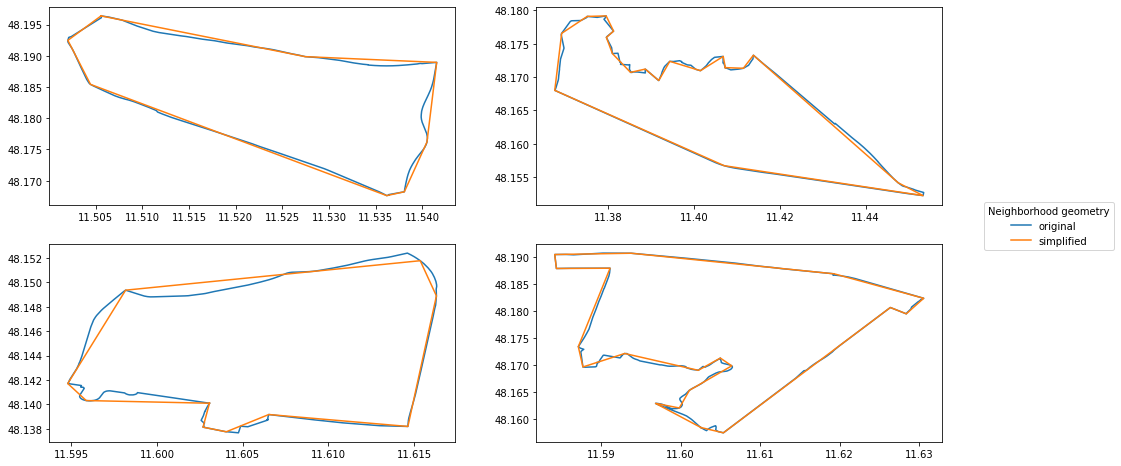

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(16,8))

axes[0,0].plot(*muc_nhood_bounds['geometry'][0].exterior.xy)
axes[0,0].plot(*muc_nhood_bounds_smplfd['geometry'][0].exterior.xy)

axes[0,1].plot(*muc_nhood_bounds['geometry'][1].exterior.xy)
axes[0,1].plot(*muc_nhood_bounds_smplfd['geometry'][1].exterior.xy)

axes[1,0].plot(*muc_nhood_bounds['geometry'][2].exterior.xy)
axes[1,0].plot(*muc_nhood_bounds_smplfd['geometry'][2].exterior.xy)

axes[1,1].plot(*muc_nhood_bounds['geometry'][3].exterior.xy)
axes[1,1].plot(*muc_nhood_bounds_smplfd['geometry'][3].exterior.xy)

line_labels = ["original", "simplified"]

# Create legend
fig.legend(labels=line_labels,
           loc="center right",
           bbox_to_anchor=(1.05, 0.5),
           borderaxespad=0.1,
           title="Neighborhood geometry"
           );



<a id='venue_data'></a>

### 1.3 Prepare venue data [<font size="1">(table of content)</font>](#content)

In Foursquare there are five main categories that are of interest for this analysis:

1. Arts & Entertainment (e.g. art galleries, museums, theaters, cinemas, stadiums)
2. Food (e.g. restaurants, pubs, cafés)
3. Nightlife Spot (e.g. bars, nightclubs)
4. Outdoors & Recreation (e.g. parks, forests)
5. Shop & Service (e.g. clothing stores, bookstores, flower shop)

In specifying a venue's category, users can choose from a nested list of subcategories allowing up to three levels of subcategories below a venue's main category. The following procedure is used to retrieve this subcategory structure and to identify the corresponding main category of each venue in our data set.

<a id='foursquare'></a>

### 1.3.1 Retrieve venue information from Foursquare [<font size="1">(table of content)</font>](#content)

In [9]:
# set foursquare credentials
CLIENT_ID = 'AQCSYP3G3LFTG51R1XM0USP5B2RZRWN1BYRS0VSECLT10N12'
CLIENT_SECRET = 'TVQ5M4JB0ZIFSWMOKNWCOCZINB2DJCKVAOK1M5NYPZOU53MA'
VERSION = 20201102

In [10]:
# function to retrieve venues within neighborhood polygons
def GetVenuesWithinPolygon(names, polygon):
    
    venues_list=[]
    i=0
    for name, polygon in zip(names, polygon):
        i=i+1
        print(i)
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&polygon={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            polygon)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each venue within a polygon
        venues_list.append([(
            name, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category - match',
                  'Venue Category ID - match']
    
    return(nearby_venues)

In [11]:
# translate simplified polygons into geometry string 
# that can be read by foursquare api
import re
from shapely import wkt
from shapely.ops import transform

def flip(x, y):
    """Flips the x and y coordinate values"""
    return y, x

muc_nhood_bounds_smplfd['geometry_string'] = ''

for i in range(0,len(muc_nhood_bounds_smplfd)):
    
    print('\n',i, muc_nhood_bounds_smplfd['Neighborhood'][i])
    
    geometry_string = muc_nhood_bounds_smplfd['geometry'][i]
    geometry_string = transform(flip, geometry_string).wkt
    geometry_string = re.findall('POLYGON \(\((.*)\)\)', geometry_string)
    geometry_string = ''.join(geometry_string)
    geometry_string = geometry_string.replace(', ', '%3B').replace(' ','%2C')
    
    muc_nhood_bounds_smplfd['geometry_string'][i] = geometry_string


 0 Alt Moosach

 1 Altaubing

 2 Altbogenhausen

 3 Alte Heide - Hirschau

 4 Alte Kaserne

 5 Altperlach

 6 Am Hart

 7 Am Luitpoldpark

 8 Am Riesenfeld

 9 Am Schlachthof

 10 Am Waldfriedhof

 11 Am Westbad

 12 Am alten nördlichen Friedhof

 13 Am alten südlichen Friedhof

 14 Angerviertel

 15 Aubing-Süd

 16 Augustenstraße

 17 Balanstraße-West

 18 Berg am Laim Ost

 19 Biederstein

 20 Blumenau

 21 Daglfing

 22 Deutsches Museum

 23 Dom Pedro

 24 Dreimühlen

 25 Echarding

 26 Englischer Garten Süd

 27 Englschalking

 28 Feldmoching

 29 Forstenried

 30 Freiham

 31 Freimann

 32 Friedenheim

 33 Fürstenried-West

 34 Gartenstadt Trudering

 35 Giesing

 36 Glockenbach

 37 Graggenau

 38 Großhadern

 39 Gärtnerplatz

 40 Hackenviertel

 41 Haidhausen - Nord

 42 Haidhausen - Süd

 43 Harlaching

 44 Hasenbergl-Lerchenau Ost

 45 Herzogpark

 46 Industriebezirk

 47 Johanneskirchen

 48 Josephsburg

 49 Josephsplatz

 50 Kleinhesselohe

 51 Kreuzviertel

 52 Königsplatz

<ipython-input-11-d18f3ff90a30>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muc_nhood_bounds_smplfd['geometry_string'][i] = geometry_string


In [12]:
# call the function 'GetVenuesWithinPolygon' to retrieve venue data
muc_venues = GetVenuesWithinPolygon(names = muc_nhood_bounds_smplfd['Neighborhood'],
                                        polygon = muc_nhood_bounds_smplfd['geometry_string'])

1
Alt Moosach
2
Altaubing
3
Altbogenhausen
4
Alte Heide - Hirschau
5
Alte Kaserne
6
Altperlach
7
Am Hart
8
Am Luitpoldpark
9
Am Riesenfeld
10
Am Schlachthof
11
Am Waldfriedhof
12
Am Westbad
13
Am alten nördlichen Friedhof
14
Am alten südlichen Friedhof
15
Angerviertel
16
Aubing-Süd
17
Augustenstraße
18
Balanstraße-West
19
Berg am Laim Ost
20
Biederstein
21
Blumenau
22
Daglfing
23
Deutsches Museum
24
Dom Pedro
25
Dreimühlen
26
Echarding
27
Englischer Garten Süd
28
Englschalking
29
Feldmoching
30
Forstenried
31
Freiham
32
Freimann
33
Friedenheim
34
Fürstenried-West
35
Gartenstadt Trudering
36
Giesing
37
Glockenbach
38
Graggenau
39
Großhadern
40
Gärtnerplatz
41
Hackenviertel
42
Haidhausen - Nord
43
Haidhausen - Süd
44
Harlaching
45
Hasenbergl-Lerchenau Ost
46
Herzogpark
47
Industriebezirk
48
Johanneskirchen
49
Josephsburg
50
Josephsplatz
51
Kleinhesselohe
52
Kreuzviertel
53
Königsplatz
54
Land in Sonne
55
Lehel
56
Lerchenau West
57
Lochhausen
58
Ludwigsfeld
59
Ludwigsvorstadt-Kliniken
60


In [13]:
pd.options.display.max_rows = 6

muc_venues

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category - match,Venue Category ID - match
0,Alt Moosach,body + soul Center München Nord,48.178370,11.537157,Gym / Fitness Center,4bf58dd8d48988d175941735
1,Alt Moosach,The Flag,48.178255,11.533790,Bed & Breakfast,4bf58dd8d48988d1f8931735
2,Alt Moosach,Osteria da Massimo,48.169321,11.533054,Italian Restaurant,4bf58dd8d48988d110941735
...,...,...,...,...,...,...
3027,Westend,Ça Va,48.134756,11.539261,Café,4bf58dd8d48988d16d941735
3028,Westend,Hansa 39,48.129208,11.533877,Music Venue,4bf58dd8d48988d1e5931735
3029,Westend,Feneberg,48.137212,11.540546,Grocery Store,4bf58dd8d48988d118951735


In [14]:
print("The data frame 'muc_venues' contains",muc_venues.shape[0],"venues.")
print("The data covers",len(muc_venues['Venue Category ID - match'].unique()),"different venue categories and contains information for",len(muc_venues['Neighborhood'].unique()),"different neighborhoods") 

The data frame 'muc_venues' contains 3030 venues.
The data covers 288 different venue categories and contains information for 108 different neighborhoods


<a id='categories'></a>

### 1.3.2 Retrieve structure of venue categories [<font size="1">(table of content)</font>](#content)

In [15]:
# structure of venue categories is provided through foursquare api
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)

# category structure comes in json-format, has to be flattened individually for all subcategory levels
category_results = requests.get(url).json()

In [16]:
# lowest subcategory level: category level 4

venue_categories_4 = pd.json_normalize(category_results['response'],
                                          record_path = ['categories', 'categories', 'categories','categories'],                                              
                                          meta = [
                                                  ['categories', 'id'],
                                                  ['categories', 'name'],
                                                  ['categories', 'categories', 'id'],
                                                  ['categories', 'categories', 'name'],
                                                  ['categories', 'categories', 'categories', 'id'],
                                                  ['categories', 'categories', 'categories', 'name']
                                                  ]
                                         )

venue_categories_4.drop(venue_categories_4.columns[range(2,7)], axis = 1, inplace = True)
venue_categories_4.rename(
    columns = {
    'id' : 'Venue Category ID - Level 4',
    'name' : 'Venue Category - Level 4',
    'categories.id' : 'Venue Category ID - Level 1',
    'categories.name' : 'Venue Category - Level 1',
    'categories.categories.id' : 'Venue Category ID - Level 2',
    'categories.categories.name' : 'Venue Category - Level 2',
    'categories.categories.categories.id' : 'Venue Category ID - Level 3',
    'categories.categories.categories.name' : 'Venue Category - Level 3'},
    inplace = True
)

venue_categories_4 = venue_categories_4[[
    'Venue Category ID - Level 1',
    'Venue Category - Level 1',
    'Venue Category ID - Level 2',
    'Venue Category - Level 2',
    'Venue Category ID - Level 3',
    'Venue Category - Level 3',
    'Venue Category ID - Level 4',
    'Venue Category - Level 4']]


print('At category level 4 there are', venue_categories_4.shape[0], 'subcategories')
venue_categories_4.head()

At category level 4 there are 94 subcategories


,Venue Category ID - Level 1,Venue Category - Level 1,Venue Category ID - Level 2,Venue Category - Level 2,Venue Category ID - Level 3,Venue Category - Level 3,Venue Category ID - Level 4,Venue Category - Level 4
0,4d4b7105d754a06374d81259,Food,4bf58dd8d48988d142941735,Asian Restaurant,4bf58dd8d48988d145941735,Chinese Restaurant,52af3a5e3cf9994f4e043bea,Anhui Restaurant
1,4d4b7105d754a06374d81259,Food,4bf58dd8d48988d142941735,Asian Restaurant,4bf58dd8d48988d145941735,Chinese Restaurant,52af3a723cf9994f4e043bec,Beijing Restaurant
2,4d4b7105d754a06374d81259,Food,4bf58dd8d48988d142941735,Asian Restaurant,4bf58dd8d48988d145941735,Chinese Restaurant,52af3a7c3cf9994f4e043bed,Cantonese Restaurant
3,4d4b7105d754a06374d81259,Food,4bf58dd8d48988d142941735,Asian Restaurant,4bf58dd8d48988d145941735,Chinese Restaurant,58daa1558bbb0b01f18ec1d3,Cha Chaan Teng
4,4d4b7105d754a06374d81259,Food,4bf58dd8d48988d142941735,Asian Restaurant,4bf58dd8d48988d145941735,Chinese Restaurant,52af3a673cf9994f4e043beb,Chinese Aristocrat Restaurant


In [17]:
# second lowest subcategory level: category level 3

import numpy as np

venue_categories_3 = pd.json_normalize(category_results['response'],
                                          record_path = ['categories', 'categories', 'categories'],                                              
                                          meta = [
                                                  ['categories', 'id'],
                                                  ['categories', 'name'],
                                                  ['categories', 'categories', 'id'],
                                                  ['categories', 'categories', 'name']
                                                 ]
                                         )

venue_categories_3.drop(venue_categories_3.columns[range(2,7)], axis = 1, inplace = True)
venue_categories_3.rename(
    columns = {
    'id' : 'Venue Category ID - Level 3',
    'name' : 'Venue Category - Level 3',
    'categories.id' : 'Venue Category ID - Level 1',
    'categories.name' : 'Venue Category - Level 1',
    'categories.categories.id' : 'Venue Category ID - Level 2',
    'categories.categories.name' : 'Venue Category - Level 2'},
    inplace = True
)

venue_categories_3 = venue_categories_3[[
    'Venue Category ID - Level 1',
    'Venue Category - Level 1',
    'Venue Category ID - Level 2',
    'Venue Category - Level 2',
    'Venue Category ID - Level 3',
    'Venue Category - Level 3']]

venue_categories_3[[
    'Venue Category ID - Level 4',
    'Venue Category - Level 4']] = np.nan


print('At category level 3 there are', venue_categories_3.shape[0], 'subcategories')
venue_categories_3.head()

At category level 3 there are 382 subcategories


,Venue Category ID - Level 1,Venue Category - Level 1,Venue Category ID - Level 2,Venue Category - Level 2,Venue Category ID - Level 3,Venue Category - Level 3,Venue Category ID - Level 4,Venue Category - Level 4
0,4d4b7104d754a06370d81259,Arts & Entertainment,4bf58dd8d48988d17f941735,Movie Theater,56aa371be4b08b9a8d5734de,Drive-in Theater,NaN,NaN
1,4d4b7104d754a06370d81259,Arts & Entertainment,4bf58dd8d48988d17f941735,Movie Theater,4bf58dd8d48988d17e941735,Indie Movie Theater,NaN,NaN
2,4d4b7104d754a06370d81259,Arts & Entertainment,4bf58dd8d48988d17f941735,Movie Theater,4bf58dd8d48988d180941735,Multiplex,NaN,NaN
3,4d4b7104d754a06370d81259,Arts & Entertainment,4bf58dd8d48988d181941735,Museum,4bf58dd8d48988d18f941735,Art Museum,NaN,NaN
4,4d4b7104d754a06370d81259,Arts & Entertainment,4bf58dd8d48988d181941735,Museum,559acbe0498e472f1a53fa23,Erotic Museum,NaN,NaN


In [18]:
# first subcategory level: category level 2

venue_categories_2 = pd.json_normalize(category_results['response'],
                                          record_path = ['categories', 'categories'],                                              
                                          meta = [
                                                  ['categories', 'id'],
                                                  ['categories', 'name'],
                                                 ]
                                         )

venue_categories_2.drop(venue_categories_2.columns[range(2,7)], axis = 1, inplace = True)
venue_categories_2.rename(
    columns = {
    'id' : 'Venue Category ID - Level 2',
    'name' : 'Venue Category - Level 2',
    'categories.id' : 'Venue Category ID - Level 1',
    'categories.name' : 'Venue Category - Level 1'},
    inplace = True
)

venue_categories_2 = venue_categories_2[[
    'Venue Category ID - Level 1',
    'Venue Category - Level 1',
    'Venue Category ID - Level 2',
    'Venue Category - Level 2']]

venue_categories_2[[
    'Venue Category ID - Level 3',
    'Venue Category - Level 3',
    'Venue Category ID - Level 4',
    'Venue Category - Level 4']] = np.nan

print('At category level 2 there are', venue_categories_2.shape[0], 'subcategories')
venue_categories_2.head()

At category level 2 there are 470 subcategories


,Venue Category ID - Level 1,Venue Category - Level 1,Venue Category ID - Level 2,Venue Category - Level 2,Venue Category ID - Level 3,Venue Category - Level 3,Venue Category ID - Level 4,Venue Category - Level 4
0,4d4b7104d754a06370d81259,Arts & Entertainment,56aa371be4b08b9a8d5734db,Amphitheater,NaN,NaN,NaN,NaN
1,4d4b7104d754a06370d81259,Arts & Entertainment,4fceea171983d5d06c3e9823,Aquarium,NaN,NaN,NaN,NaN
2,4d4b7104d754a06370d81259,Arts & Entertainment,4bf58dd8d48988d1e1931735,Arcade,NaN,NaN,NaN,NaN
3,4d4b7104d754a06370d81259,Arts & Entertainment,4bf58dd8d48988d1e2931735,Art Gallery,NaN,NaN,NaN,NaN
4,4d4b7104d754a06370d81259,Arts & Entertainment,4bf58dd8d48988d1e4931735,Bowling Alley,NaN,NaN,NaN,NaN


In [19]:
# level of main categories: category level 1

venue_categories_1 = pd.json_normalize(category_results['response'],
                                          record_path = ['categories']                                              
                                         )

venue_categories_1.drop(venue_categories_1.columns[range(2,7)], axis = 1, inplace = True)
venue_categories_1.rename(
    columns = {
    'id' : 'Venue Category ID - Level 1',
    'name' : 'Venue Category - Level 1'},
    inplace = True
)

venue_categories_1 = venue_categories_1[[
    'Venue Category ID - Level 1',
    'Venue Category - Level 1']]

venue_categories_1[[
    'Venue Category ID - Level 2',
    'Venue Category - Level 2',
    'Venue Category ID - Level 3',
    'Venue Category - Level 3',
    'Venue Category ID - Level 4',
    'Venue Category - Level 4']] = np.nan

print('There are', venue_categories_1.shape[0], 'main categories')
venue_categories_1.head()

There are 10 main categories


,Venue Category ID - Level 1,Venue Category - Level 1,Venue Category ID - Level 2,Venue Category - Level 2,Venue Category ID - Level 3,Venue Category - Level 3,Venue Category ID - Level 4,Venue Category - Level 4
0,4d4b7104d754a06370d81259,Arts & Entertainment,NaN,NaN,NaN,NaN,NaN,NaN
1,4d4b7105d754a06372d81259,College & University,NaN,NaN,NaN,NaN,NaN,NaN
2,4d4b7105d754a06373d81259,Event,NaN,NaN,NaN,NaN,NaN,NaN
3,4d4b7105d754a06374d81259,Food,NaN,NaN,NaN,NaN,NaN,NaN
4,4d4b7105d754a06376d81259,Nightlife Spot,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# summarize all main categories and the corresponding subcategories in one data set 'venue_categories'

venue_categories = venue_categories_1.append([venue_categories_2, venue_categories_3,venue_categories_4], ignore_index = True)

venue_categories['Venue Category ID - match'] = venue_categories['Venue Category ID - Level 4']
venue_categories[ 'Venue Category - match'] = venue_categories['Venue Category - Level 4']
venue_categories['Venue Category ID - match'].fillna(venue_categories['Venue Category ID - Level 3'], inplace=True)
venue_categories['Venue Category - match'].fillna(venue_categories['Venue Category - Level 3'], inplace=True)
venue_categories['Venue Category ID - match'].fillna(venue_categories['Venue Category ID - Level 2'], inplace=True)
venue_categories['Venue Category - match'].fillna(venue_categories['Venue Category - Level 2'], inplace=True)
venue_categories['Venue Category ID - match'].fillna(venue_categories['Venue Category ID - Level 1'], inplace=True)
venue_categories['Venue Category - match'].fillna(venue_categories['Venue Category - Level 1'], inplace=True)

pd.options.display.max_rows = 999
print(venue_categories.isnull().sum(axis = 0))

Venue Category ID - Level 1      0
Venue Category - Level 1         0
Venue Category ID - Level 2     10
Venue Category - Level 2        10
Venue Category ID - Level 3    480
Venue Category - Level 3       480
Venue Category ID - Level 4    862
Venue Category - Level 4       862
Venue Category ID - match        0
Venue Category - match           0
dtype: int64


In [21]:
pd.options.display.max_rows = 6
venue_categories

,Venue Category ID - Level 1,Venue Category - Level 1,Venue Category ID - Level 2,Venue Category - Level 2,Venue Category ID - Level 3,Venue Category - Level 3,Venue Category ID - Level 4,Venue Category - Level 4,Venue Category ID - match,Venue Category - match
0,4d4b7104d754a06370d81259,Arts & Entertainment,NaN,NaN,NaN,NaN,NaN,NaN,4d4b7104d754a06370d81259,Arts & Entertainment
1,4d4b7105d754a06372d81259,College & University,NaN,NaN,NaN,NaN,NaN,NaN,4d4b7105d754a06372d81259,College & University
2,4d4b7105d754a06373d81259,Event,NaN,NaN,NaN,NaN,NaN,NaN,4d4b7105d754a06373d81259,Event
...,...,...,...,...,...,...,...,...,...,...
953,4d4b7105d754a06377d81259,Outdoors & Recreation,4f4528bc4b90abdf24c9de85,Athletics & Sports,4bf58dd8d48988d175941735,Gym / Fitness Center,590a0744340a5803fd8508c3,Weight Loss Center,590a0744340a5803fd8508c3,Weight Loss Center
954,4d4b7105d754a06377d81259,Outdoors & Recreation,4f4528bc4b90abdf24c9de85,Athletics & Sports,4bf58dd8d48988d175941735,Gym / Fitness Center,4bf58dd8d48988d102941735,Yoga Studio,4bf58dd8d48988d102941735,Yoga Studio
955,4d4b7105d754a06375d81259,Professional & Other Places,4bf58dd8d48988d104941735,Medical Center,4bf58dd8d48988d196941735,Hospital,58daa1558bbb0b01f18ec1f7,Hospital Ward,58daa1558bbb0b01f18ec1f7,Hospital Ward


<a id='muc_nhood_venues'></a>

### 1.3.3 Create neighborhood level venue data [<font size="1">(table of content)</font>](#content)

####  Merge venue data and category structure to obtain each venue's main category

In [22]:
muc_venues_full = muc_venues.merge(venue_categories, how = 'left', on = ['Venue Category ID - match', 'Venue Category - match'])

In [23]:
# drop venues from main categories 'Professional & Other Places', 'Travel & Transport', and 'Residence' 
muc_venues_full.drop(muc_venues_full[(muc_venues_full['Venue Category - Level 1'] == 'Professional & Other Places')
                                     | (muc_venues_full['Venue Category - Level 1'] == 'Travel & Transport')
                                     | (muc_venues_full['Venue Category - Level 1'] == 'Residence')
                                    ].index, inplace = True)

In [24]:
muc_venues_full.head()

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category - match,Venue Category ID - match,Venue Category ID - Level 1,Venue Category - Level 1,Venue Category ID - Level 2,Venue Category - Level 2,Venue Category ID - Level 3,Venue Category - Level 3,Venue Category ID - Level 4,Venue Category - Level 4
0,Alt Moosach,body + soul Center München Nord,48.178370,11.537157,Gym / Fitness Center,4bf58dd8d48988d175941735,4d4b7105d754a06377d81259,Outdoors & Recreation,4f4528bc4b90abdf24c9de85,Athletics & Sports,4bf58dd8d48988d175941735,Gym / Fitness Center,NaN,NaN
2,Alt Moosach,Osteria da Massimo,48.169321,11.533054,Italian Restaurant,4bf58dd8d48988d110941735,4d4b7105d754a06374d81259,Food,4bf58dd8d48988d110941735,Italian Restaurant,NaN,NaN,NaN,NaN
3,Alt Moosach,Alter Wirt Moosach,48.181014,11.512222,German Restaurant,4bf58dd8d48988d10d941735,4d4b7105d754a06374d81259,Food,4bf58dd8d48988d10d941735,German Restaurant,NaN,NaN,NaN,NaN
4,Alt Moosach,JustMusic,48.185000,11.531130,Music Store,4bf58dd8d48988d1fe941735,4d4b7105d754a06378d81259,Shop & Service,4bf58dd8d48988d1fe941735,Music Store,NaN,NaN,NaN,NaN
5,Alt Moosach,Fruchtwerk,48.183547,11.532726,Juice Bar,4bf58dd8d48988d112941735,4d4b7105d754a06374d81259,Food,4bf58dd8d48988d112941735,Juice Bar,NaN,NaN,NaN,NaN


In [25]:
pd.options.display.max_rows = 999
muc_venues_full.isnull().sum(axis = 0)

Neighborhood                      0
Venue                             0
Venue Latitude                    0
Venue Longitude                   0
Venue Category - match            0
Venue Category ID - match         0
Venue Category ID - Level 1       0
Venue Category - Level 1          0
Venue Category ID - Level 2       8
Venue Category - Level 2          8
Venue Category ID - Level 3    1811
Venue Category - Level 3       1811
Venue Category ID - Level 4    2667
Venue Category - Level 4       2667
dtype: int64

#### One-hot encoding for main venue categories

In [26]:
# generate one-hot encoded dataset on venue categories
muc_onehot = pd.get_dummies(muc_venues_full[['Venue Category - Level 1']], prefix="", prefix_sep="")

# add the variable "Neighborhood"
muc_onehot['Neighborhood'] = muc_venues_full['Neighborhood']

# change the order of columns
fixed_columns = [muc_onehot.columns[-1]] + list(muc_onehot.columns[:-1])
muc_onehot = muc_onehot[fixed_columns]

In [27]:
muc_onehot.head()

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service
0,Alt Moosach,0,0,0,1,0
2,Alt Moosach,0,1,0,0,0
3,Alt Moosach,0,1,0,0,0
4,Alt Moosach,0,0,0,0,1
5,Alt Moosach,0,1,0,0,0


In [28]:
print("The data frame 'muc_onehot' contains one-hot encoded data on",muc_onehot.shape[0],"venues.")
print("The data covers",muc_onehot.shape[1]-1,"different venue categories and contains information for",len(muc_onehot['Neighborhood'].unique()),"different neighborhoods") 

The data frame 'muc_onehot' contains one-hot encoded data on 2720 venues.
The data covers 5 different venue categories and contains information for 108 different neighborhoods


#### Collapse one-hot encoded venue data on the neighborhood level

In [29]:
muc_nhood_venues = muc_onehot.groupby('Neighborhood').sum().reset_index()
muc_nhood_venues = muc_nhood_bounds_smplfd[['Neighborhood']].join(muc_nhood_venues.set_index('Neighborhood'), on='Neighborhood')

<a id='muc_complete'></a>

### 1.4 Merge geodata and venue information [<font size="1">(table of content)</font>](#content)

In [30]:
muc_complete = muc_nhood_bounds.join(muc_nhood_venues.set_index('Neighborhood'), on='Neighborhood')
muc_complete = muc_complete[[c for c in muc_complete if c not in ['geometry']] + ['geometry']]

In [31]:
pd.options.display.max_rows = 6
muc_complete

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,geometry
0,Alt Moosach,1,15,0,3,9,"POLYGON ((11.50558 48.19638, 11.50561 48.19610..."
1,Altaubing,0,7,0,5,8,"POLYGON ((11.40730 48.17139, 11.40709 48.17178..."
2,Altbogenhausen,2,16,1,4,5,"POLYGON ((11.60306 48.14009, 11.60292 48.13977..."
...,...,...,...,...,...,...,...
105,Waldperlach,0,5,1,4,4,"POLYGON ((11.65432 48.08047, 11.65523 48.08029..."
106,Waldtrudering,0,13,2,3,5,"POLYGON ((11.66492 48.10219, 11.66489 48.10207..."
107,Westend,2,19,3,3,2,"POLYGON ((11.53542 48.12986, 11.53567 48.12988..."


<a id='data_visualization'></a>

### 2. Data visualization [<font size="1">(table of content)</font>](#content)

<a id='heat_cat'></a>

### 2.1 Heat maps by venue category  [<font size="1">(table of content)</font>](#content)

In [32]:
# Prepare heat map label containing number of venues within category as well as the neighborhoods rank in that category

variables = ['Arts & Entertainment', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Shop & Service']

for var in variables:
    muc_complete[var + ' (rank)'] = (muc_complete[var].rank(axis=0, method='min', na_option='keep', ascending=False, pct=False)).astype(int)
    muc_complete[var + ' (label)'] = muc_complete[var].astype(str) + ' venues (' + muc_complete[var + ' (rank)'].astype(str) + '. rank)'

pd.options.display.max_rows = 1
muc_complete

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,geometry,Arts & Entertainment (rank),Arts & Entertainment (label),Food (rank),Food (label),Nightlife Spot (rank),Nightlife Spot (label),Outdoors & Recreation (rank),Outdoors & Recreation (label),Shop & Service (rank),Shop & Service (label)
0,Alt Moosach,1,15,0,3,9,"POLYGON ((11.50558 48.19638, 11.50561 48.19610...",39,1 venues (39. rank),39,15 venues (39. rank),81,0 venues (81. rank),44,3 venues (44. rank),19,9 venues (19. rank)


In [33]:
import matplotlib.pyplot as plt
import ipywidgets as wdgts
import scipy.cluster.hierarchy as shc
import folium
from geopy.geocoders import Nominatim
from IPython.display import HTML


# specify the dropdown menu for selection of venue category
category_dropdown = wdgts.Dropdown(
                    options = ['Arts & Entertainment', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Shop & Service'],
                    value = 'Arts & Entertainment',
                    description='Choose a venue category:',
                    style = {'description_width': 'initial'},
                    layout=wdgts.Layout(width='45%'))

# define dictionary for rank and label variables
variables = ['Arts & Entertainment', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Shop & Service']
rank_vars = {}
label_vars = {}
for var in variables:
    rank_vars[var] = var + ' (rank)'    
    label_vars[var] = var + ' (label)'
   
# retrieve center location for folium map                              
geolocator = Nominatim(user_agent = "foursquare_agent")
location = geolocator.geocode("München")
muc_lat = location.latitude
muc_lon = location.longitude

# convert to geopandas.dataframe
muc_complete_gpd = geopandas.GeoDataFrame(muc_complete, crs = "WGS84", geometry=muc_complete.geometry)                             

# define fill color for each category
fill_colors = {'Arts & Entertainment': 'Purples',
               'Food': 'Oranges',
               'Nightlife Spot': 'Blues',
               'Outdoors & Recreation': 'Greens',
               'Shop & Service': 'Greys'}


                              
def map_interact(category):
    
    fig = folium.Figure(width=800, height=450)
    
    muc_map = folium.Map(location = [muc_lat+.012, muc_lon], zoom_start = 11, tiles = 'cartodbpositron')  
    
    myscale = (np.linspace(muc_complete_gpd[category].min(),muc_complete_gpd[category].max(),10)).tolist()

    folium.Choropleth(
        geo_data = muc_complete_gpd,
        name = 'choropleth',
        data = muc_complete_gpd,
        columns = ['Neighborhood', category],
        key_on = 'feature.properties.Neighborhood',
        fill_color = fill_colors[category],
        threshold_scale = myscale,
        fill_opacity = .4,
        line_opacity = .5,
        legend_name= category + ' (total number of venues)',
        highlight = True
    ).add_to(muc_map)

    folium.features.GeoJson(
        muc_complete_gpd,
        name = "popuplabels",
        highlight_function = lambda x: {'weight':2, 'color':'black'},
        style_function = lambda x: {'fillOpacity': 0.0, 'weight':0},
        popup=folium.features.GeoJsonPopup(
            fields = ['Neighborhood', label_vars[category]],
            aliases = ['Neighborhood: ',category + ':'],
            localize = True 
        )
    ).add_to(muc_map)

    folium.map.CustomPane('labels').add_to(muc_map)
    folium.TileLayer('CartoDBPositronOnlyLabels', pane='labels').add_to(muc_map)

    fig.add_child(muc_map)
    display(fig)

    # tab the neighborhoods ranking from 1 to 5
    muc_complete_selection = muc_complete_gpd[['Neighborhood', category, rank_vars[category]]].sort_values(by = category, ascending = False)
    html_table = (muc_complete_selection[muc_complete_selection[rank_vars[category]] < 6]).to_html(index = False)
    display(HTML(html_table))

    
    
out = wdgts.interactive_output(map_interact,
               {'category': category_dropdown}
               )



items = [out, category_dropdown]
items_layout = wdgts.Layout(width='auto')

box_layout = wdgts.Layout(display='flex',
                    flex_flow='column',
                    align_items='center',
                    border= None,
                    width='90%')

box = wdgts.Box(children=items, layout=box_layout)
box

    

Box(children=(Output(), Dropdown(description='Choose a venue category:', layout=Layout(width='45%'), options=(…

<a id='freq_cat'></a>

### 2.2 Relative frequency of venue types - boxplot and pairwise-plot  [<font size="1">(table of content)</font>](#content)

In [34]:
# import required libraries
import seaborn as sns

In [35]:
# convert category count variables into relative frequencies
variables = ['Arts & Entertainment', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Shop & Service']

muc_complete['venue_count'] = muc_complete[variables].sum(axis = 1)

for var in variables:
    muc_complete[var] = muc_complete[var]/muc_complete['venue_count']

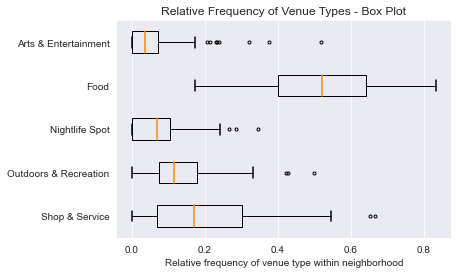

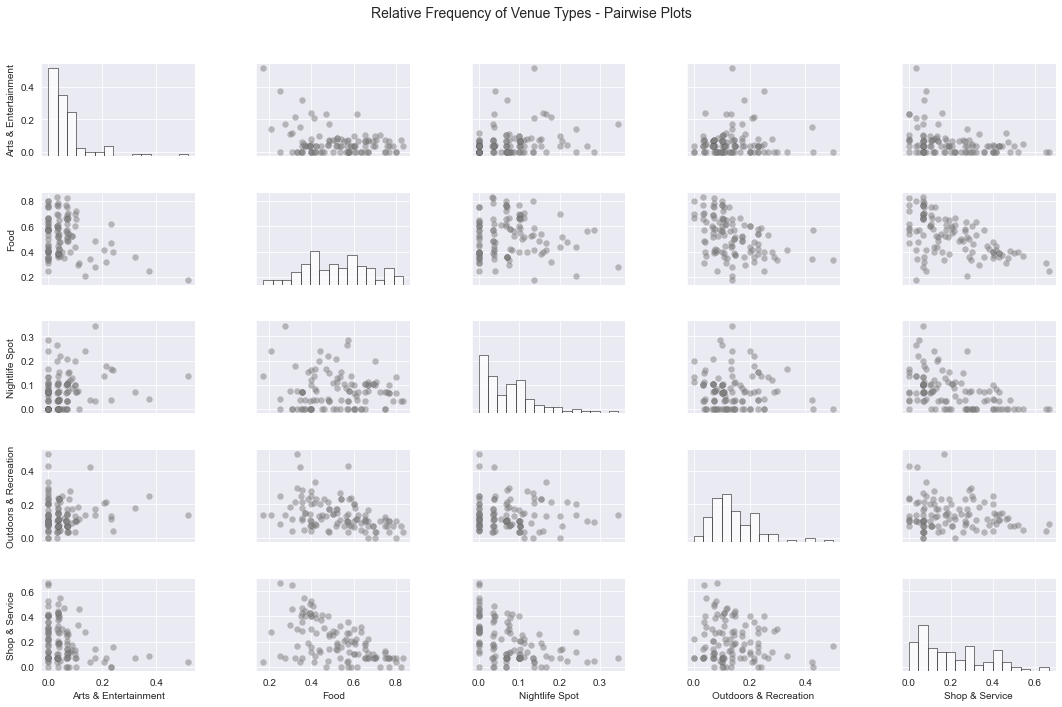

In [36]:
sns.set_style("darkgrid")

column_start = muc_complete.columns.get_loc('Arts & Entertainment')
column_end = muc_complete.columns.get_loc('Shop & Service') + 1
                                           
boxplot_catlevel1 = sns.boxplot(
                      data = muc_complete.iloc[:,column_start:column_end],
                      orient = 'h', 
                      boxprops = {'facecolor': 'none', 'edgecolor': 'black', 'linewidth': 1}, 
                      medianprops = {'color': 'darkorange'},
                      whiskerprops = {'color': 'black', 'linewidth': 1},
                      capprops = {'color': 'black'},
                      flierprops = {'marker': 'o', 'markerfacecolor': 'none', 'markeredgecolor': 'black', 'markersize': 3},
                      width = .5)

boxplot_catlevel1.set(xlabel = 'Relative frequency of venue type within neighborhood')
boxplot_catlevel1.set_title('Relative Frequency of Venue Types - Box Plot')


pairplot_catlevel1 = sns.pairplot(muc_complete.iloc[:,column_start:column_end], height = 2, aspect = 1.5,
                                  plot_kws=dict(edgecolor = "black", color = "grey", linewidth = 0.1, alpha = 0.5),
                                  diag_kind = 'hist',
                                  diag_kws=dict(bins = 15, edgecolor = "black", color = "white", linewidth = 0.5))

fig = pairplot_catlevel1.fig 
fig.subplots_adjust(top = 0.9, hspace = 0.4, wspace = 0.4)
fig.suptitle('Relative Frequency of Venue Types - Pairwise Plots', fontsize=14);

#### Box plots:
* For the absolute majority of neighborhoods, "Food" venues are the most common venue type.
* "Shop & Service" venues tend to be the second most common venue type, followed by venues of the category "Outdoors & Recreation"
* "Arts & Entertainment" and "Nightlife Spot" tend to be the least frequent venue types within neighborhoods

#### Pairplots:
* Upon visual inspection the data does not show any clearly separated clusters. The majority of graphs show at most one area of particularly high density and observations outside high density areas do not show any grouping patterns.  
* For the vast majority of neighborhoods, the categories "Arts & Entertainment" and "Nightlife Spots" account for less than 10% of all venues. In these dimensions we observe a high observation density below 10% and only a few losely scattered observations above 10%.
* The highest degree of dispersion can be observed in the venue categories "Food" and "Shop & Service". As a result, observation clouds tend to be stretched along these dimensions.

##### Take-away:
The data does not show clearly separated clusters. Thus, k-means might not be the most suitable clustering algorithm, as it tends to show poorer performance when clusters are non-circular/non-convex. In our analysis we will therefore also consider hierarchical agglomerative clustering.

<a id='segmentation'></a>

## 3 Neighborhood segmentation using cluster analysis   [<font size="1">(table of content)</font>](#content)

In our cluster analysis we consider K-means clustering as well as hierarchical agglomerative clustering (HAC). To narrow down the set of reasonable specifications (algorithm, number of clusters) we first collect a series of assessment metrics. Subsequently, we summarize the characteristics of the specification that appears most suitable for our purpose.

#### Standardize relative venue frequencies for cluster analysis

In [37]:
from sklearn.preprocessing import StandardScaler

muc_complete_std = muc_complete.iloc[:,:6].copy(deep = True)

muc_complete_std.iloc[:,1:muc_complete_std.shape[1]] = StandardScaler().fit_transform(muc_complete_std.iloc[:,1:muc_complete_std.shape[1]].to_numpy())

In [38]:
pd.options.display.max_rows = 6
muc_complete_std

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service
0,Alt Moosach,-0.292171,0.086815,-1.067976,-0.344456,0.745128
1,Altaubing,-0.729995,-1.132942,-1.067976,1.264373,1.243004
2,Altbogenhausen,0.145653,0.321384,-0.568670,0.057751,-0.160100
...,...,...,...,...,...,...
105,Waldperlach,-0.729995,-1.086029,-0.069364,1.666580,0.518821
106,Waldtrudering,-0.729995,0.280590,0.147726,-0.082147,0.085886
107,Westend,0.115459,0.871407,0.378290,-0.386064,-0.854628


<a id='metrics'></a>

<a id='kmeans'></a>

### 3.1 Assessment metrics for K-means  [<font size="1">(table of content)</font>](#content)

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

def kmeans_evaluation(points, kmax):

    # global dictionary "kmeans_data" to export cluster labels
    global kmeans_data
    kmeans_data = {}

    # lists to store assessment metrics
    wcsse = []
    silhouette = []
    ch_index = []
    db_index = []
    
    kmeans = KMeans(n_clusters = 1, n_init = 1000, init = 'k-means++', random_state=123).fit(points)

    #extract labels generated by k-means algorithm
    kmeans_data['kmeans_' + str(1) + 'clusters'] = labels = kmeans.labels_

    # extract within-cluster-sum of squared errors (WCSSE)
    wcsse.append(kmeans.inertia_)
    
 
    for k in range(2, kmax+1):
    
        kmeans = KMeans(n_clusters = k, n_init = 1000, init = 'k-means++', random_state=123).fit(points)
    
        #extract labels generated by k-means algorithm
        kmeans_data['kmeans_' + str(k) + 'clusters'] = labels = kmeans.labels_

        # extract within-cluster-sum of squared errors (WCSSE)
        wcsse.append(kmeans.inertia_)
        
        # calculate and append silhouette score for the entire sample
        silhouette.append(silhouette_score(points, labels, metric = 'euclidean'))

        # calculate and append calinski-harabasz index
        ch_index.append(calinski_harabasz_score(points, labels))    

        # calculate and append davies-bouldin index    
        db_index.append(davies_bouldin_score(points, labels))
        
    
    kmeans_data['wcsse'] = wcsse
    kmeans_data['silhouette'] = silhouette
    kmeans_data['ch_index'] = ch_index
    kmeans_data['db_index'] = db_index
   

In [40]:
muc_complete_clust = muc_complete_std.drop('Neighborhood', 1).copy(deep = True)
kmeans_evaluation(muc_complete_clust, 20)

<a id='hac'></a>

### 3.2 Assessment metrics for hierarchical  agglomerative clustering (HAC)  [<font size="1">(table of content)</font>](#content)

#### Dendrogramms

In [41]:
import matplotlib.pyplot as plt
import ipywidgets as wdgts
import scipy.cluster.hierarchy as shc

# specify the dropdown menu for selection of linkage method

level_dropdown = wdgts.Dropdown(
                    options = [("Ward's criterion", 'ward'), ('complete linkage', 'complete'), ('average linkage', 'average')],
                    value = 'ward',
                    description='Choose a linkage method:',
                    style = {'description_width': 'initial'},
                    layout=wdgts.Layout(width='45%'))


# identify the maximum thresholds depending on the selected linkage method
linkage_list = ['ward', 'complete', 'average']
max_threshold = {}

for linkage_option in linkage_list:
     dend_noshow = shc.dendrogram(shc.linkage(y = muc_complete_clust, method = linkage_option), no_plot = True)
     max_threshold[linkage_option] = np.max(dend_noshow['dcoord'])   

# specify the slider menu for selection of threshold level (initialized with maximum threshold for 'column_limit_L1')
threshold_slider = wdgts.FloatSlider(
                    min = 1.0, max = max_threshold['ward'], step = 0.1, value = 1.0,
                    continuous_update = False, 
                    description='Choose a threshold value:',
                    style = {'description_width': 'initial'},
                    layout=wdgts.Layout(width='45%')
                   )


def update(change):
    threshold_slider.max = max_threshold[change.new]
    threshold_slider.value = 1    
level_dropdown.observe(update, names = 'value')


def dend_interact(linkage_method, threshold):

        fig = plt.figure(figsize=(28, 14))
        
        ax = fig.add_subplot(1, 1, 1)
        ax.tick_params(axis = 'y', which = 'major', labelsize=16)
        ax.set_title("Dendrogram - Hierarchical Agglomerative Clustering (HAC)", fontsize = 20) 

        dend = shc.dendrogram(shc.linkage(y = muc_complete_clust, method = linkage_method), color_threshold = threshold, above_threshold_color = 'black', link_color_func = None, no_labels = True, ax = ax)

        plt.axhline(y = threshold, c='k', linestyle ='dashed')

out = wdgts.interactive_output(dend_interact,
               {'linkage_method': level_dropdown,
               'threshold': threshold_slider}
               )




items = [out, level_dropdown, threshold_slider]
items_layout = wdgts.Layout(width='auto')

box_layout = wdgts.Layout(display='flex',
                    flex_flow='column',
                    align_items='center',
                    border= None,
                    width='90%')

box = wdgts.Box(children=items, layout=box_layout)
box

Box(children=(Output(), Dropdown(description='Choose a linkage method:', layout=Layout(width='45%'), options=(…

In this dendrogramm, we consider three potential linkage methods: 'Ward's criterion', 'complete linkage', and 'average linkage'. Of the three considered linkage methods, linkage according to Ward's criterion appears to be the most suitable method for our purposes. Starting from a relatively low threshold value (3.10 or higher, i.e. 15 or less clusters) it yields comparatively evenly sized clusters. 'Average linkage' does not appear suitable for our purposes. For a wide range of threshold values, the average linkage method produces singular clusters, while the majority of neighborhoods are grouped in the same cluster. As a result, the clusters generated by this method frequently are too narrow or too wide for the recommendation of similar neighborhoods. Therefore, we exclude 'average linkage' in the collection of assessment metrics.

#### Assessment metrics

In [42]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score


def hac_evaluation(points, clust_max):

    # define the linkage methods used by HAC algorithm
    linkage_list = ['ward', 'complete']

    # all output data (labels and metrics) are stored in hac_data
    global hac_data
    hac_data = {}
    subdict = {}
    
    for linkage_option in linkage_list:

        subdict[linkage_option] = 'hac_' + linkage_option
        hac_data[subdict[linkage_option]] = {} 
    
        # lists to export assessment metrics
        wcsse = []
        silhouette = []
        ch_index = []
        db_index = []
    
        hac = AgglomerativeClustering(
                        n_clusters = 1,
                        affinity = 'euclidean',
                        compute_full_tree = 'auto',
                        linkage = linkage_option,
                        distance_threshold = None
                        ).fit(points)
    
        # extract labels generated by HAC algorithm
        hac_data[subdict[linkage_option]]['hac_' + linkage_option + '_' + str(1) + 'clusters'] = labels = hac.labels_
    
        # extract within-cluster-sum of squared errors (WCSSE)
        data_points = points.copy(deep = True)
        data_points['labels'] = labels
        unique_labels = data_points.groupby('labels').mean()
        data_points = data_points.merge(unique_labels, how = 'left', on = 'labels')
        curr_wcsse = sum((np.linalg.norm(data_points.iloc[:,:5].values - data_points.iloc[:,6:11].values, axis = 1)) **2)
        wcsse.append(curr_wcsse)
        
    
        for n in range(2,clust_max+1):

            hac = AgglomerativeClustering(
                        n_clusters = n,
                        affinity = 'euclidean',
                        compute_full_tree = 'auto',
                        linkage = linkage_option,
                        distance_threshold = None
                        ).fit(points)
        
    
            #extract labels generated by HAC algorithm
            hac_data[subdict[linkage_option]]['hac_' + linkage_option + '_' + str(n) + 'clusters'] = labels = hac.labels_
        
            # extract within-cluster-sum of squared errors (WCSSE)
            data_points = points.copy(deep = True)
            data_points['labels'] = labels
            unique_labels = data_points.groupby('labels').mean()
            data_points = data_points.merge(unique_labels, how = 'left', on = 'labels')
            curr_wcsse = sum((np.linalg.norm(data_points.iloc[:,:5].values - data_points.iloc[:,6:11].values, axis = 1)) **2)
            wcsse.append(curr_wcsse)
            
            # calculate and append silhouette values
            silhouette.append(silhouette_score(points, labels, metric = 'euclidean'))

            # calculate and append calinski-harabasz index
            ch_index.append(calinski_harabasz_score(points, labels))    

            # calculate and append davies-bouldin index    
            db_index.append(davies_bouldin_score(points, labels))

        hac_data[subdict[linkage_option]]['wcsse'] = wcsse
        hac_data[subdict[linkage_option]]['silhouette'] = silhouette
        hac_data[subdict[linkage_option]]['ch_index'] = ch_index
        hac_data[subdict[linkage_option]]['db_index'] = db_index
   

In [43]:
hac_evaluation(muc_complete_clust, 20)

<a id='summary_metrics'></a>

### 3.3 Summary of assessment metrics   [<font size="1">(table of content)</font>](#content)

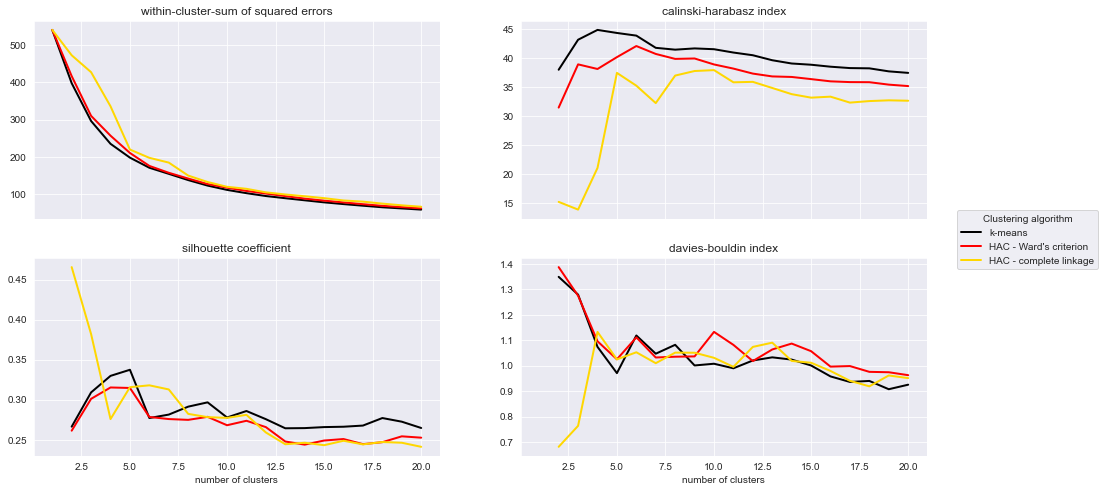

In [44]:
assessment_metrics = ['wcsse', 'ch_index', 'silhouette', 'db_index']

k_full = range(1,21)
k_fromtwo = range(2,21)

k_dict = {'wcsse': k_full,
          'ch_index': k_fromtwo, 
          'silhouette': k_fromtwo,
          'db_index': k_fromtwo}

title_dict = {'wcsse': 'within-cluster-sum of squared errors',
              'ch_index': 'calinski-harabasz index', 
              'silhouette': 'silhouette coefficient', 
              'db_index': 'davies-bouldin index'}

fig, axes = plt.subplots(ncols = 2, nrows = 2, sharex=True, figsize=(16,8))
plot_matrix = np.array(assessment_metrics).reshape(axes.shape[0], axes.shape[1])

for metric in assessment_metrics:
    
    # retrieve plot matrix indices of the current assessment metric
    i_row = np.where(plot_matrix == metric)[0][0]
    i_col = np.where(plot_matrix == metric)[1][0]
    
    # overlay lineplots for the current assessment metric 
    sns.lineplot(x = k_dict[metric], y = kmeans_data[metric], linewidth = 2.0, color = 'black', ax = axes[i_row,i_col])
    sns.lineplot(x = k_dict[metric], y = hac_data['hac_ward'][metric], linewidth = 2.0, color = 'red', ax = axes[i_row,i_col])
    sns.lineplot(x = k_dict[metric], y = hac_data['hac_complete'][metric], linewidth = 2.0, color = 'gold', ax = axes[i_row,i_col])

    # set title for lineplots of the current assessment metric 
    axes[i_row,i_col].set_title(title_dict[metric])

plt.setp(axes[-1, :], xlabel='number of clusters')
    
line_labels = ["k-means", "HAC - Ward's criterion", "HAC - complete linkage"]

# Create the legend
fig.legend(labels=line_labels,
           loc="center right",
           bbox_to_anchor=(1.05, 0.5),
           borderaxespad=0.1,
           title="Clustering algorithm"
           );


To identify the natural number of clusters in our venue data, we make use of multiple assessment metrics: 

The top left plot shows the **within-cluster-sums of squared error (WCSSE)** for a broad range of cluster numbers. Not surprisingly, the k-means algorithm tends to yield the lowest WCSSE. Yet, it is closely tracked by the clusters generated using HAC with Ward's linkage criterion. For both clustering approaches, the plotted line shows a smooth decline in WCSSE without any prominent elbow-point. For HAC with complete linkage, the plot shows multiple potential elbow points. 

The top right figure plots the **Calinski-Harabasz Index (CHI)**. Higher CHI values indicate a clearer cluster segmentation. According to the CHI, therefore, the optimal numbers of clusters appear to be 4 clusters when using k-means, 6 clusters for HAC with Ward's linkage criterion, and 10 clusters for HAC with complete linkage.

The bottom left graph shows the average **silhouette scores** depending on the number of clusters. Again, a higher average silhouette score indicates a clearer distinction between clusters. For k-means and HAC with Ward's linkage criterion this indicator is maximized at 5 clusters. For HAC with complete linkage the silhouette score is maximized at 2 clusters.

Finally, the bottom right figure plots the **Davies-Bouldin Index (DBI)**. Contrary to the previous indicators, cluster segmentation is optimized when the DBI is at its minimum. For k-means and HAC with Ward's linkage criterion the first local minimum is located at k=5. Yet, within the considered range the DBI for both clustering approaches is minimized at excessively large cluster numbers. For HAC with complete linkage the DBI is minimized at 2 clusters.

Overall, the k-means algorithm and HAC with Ward's linkage criterion appear to yield the more well-behaved cluster segmentations. For both approaches, all metrics yield similar implications on the relationship between number of clusters and clustering quality. For HAC with complete linkage the relationship between number of clusters and clustering quality appears less clear, especially as CHI and silhouette scores/DBI yield completely contradicting implications.

Therefore, will exclude HAC with complete linkage from our further analysis. Instead, we focus on k-means and HAC with Ward's linkage criterion as potentially fruitful clustering approaches. Given the findings of the considered assessment metrics, our analysis will moreover place particular focus on cluster numbers around 5.

<a id='segmentation'></a>

### 3.4 Segmentation of Munich neighborhoods   [<font size="1">(table of content)</font>](#content)

#### Merge cluster labels and neighborhood data

In [45]:
kmeans_lab = pd.DataFrame.from_dict({key: kmeans_data[key] for key in kmeans_data if key not in ['wcsse', 'silhouette', 'ch_index', 'db_index']})
hac_ward_lab = pd.DataFrame.from_dict({key: hac_data['hac_ward'][key] for key in hac_data['hac_ward'] if key not in ['wcsse', 'silhouette', 'ch_index', 'db_index']})


labels = kmeans_lab.join([hac_ward_lab])
labels.head()

,kmeans_1clusters,kmeans_2clusters,kmeans_3clusters,kmeans_4clusters,kmeans_5clusters,kmeans_6clusters,kmeans_7clusters,kmeans_8clusters,kmeans_9clusters,kmeans_10clusters,...,hac_ward_11clusters,hac_ward_12clusters,hac_ward_13clusters,hac_ward_14clusters,hac_ward_15clusters,hac_ward_16clusters,hac_ward_17clusters,hac_ward_18clusters,hac_ward_19clusters,hac_ward_20clusters
0,0,1,1,0,0,1,3,1,6,2,...,4,4,4,4,1,0,1,1,1,0
1,0,1,1,0,0,0,0,5,1,8,...,6,6,6,6,6,6,6,6,6,6
2,0,0,0,1,3,1,3,1,6,2,...,4,4,4,4,1,0,16,16,16,16
3,0,0,2,3,4,4,5,0,5,5,...,9,9,9,9,4,4,4,4,4,4
4,0,0,0,1,3,5,4,4,0,4,...,2,0,3,3,3,1,0,8,8,8


In [46]:
muc_complete_lab = muc_complete.join(labels)

In [47]:
print("Final size of the data frame:",muc_complete_lab.shape)

Final size of the data frame: (108, 58)


In [48]:
pd.options.display.max_rows = 6
muc_complete_lab

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,geometry,Arts & Entertainment (rank),Arts & Entertainment (label),Food (rank),...,hac_ward_11clusters,hac_ward_12clusters,hac_ward_13clusters,hac_ward_14clusters,hac_ward_15clusters,hac_ward_16clusters,hac_ward_17clusters,hac_ward_18clusters,hac_ward_19clusters,hac_ward_20clusters
0,Alt Moosach,0.035714,0.535714,0.000000,0.107143,0.321429,"POLYGON ((11.50558 48.19638, 11.50561 48.19610...",39,1 venues (39. rank),39,...,4,4,4,4,1,0,1,1,1,0
1,Altaubing,0.000000,0.350000,0.000000,0.250000,0.400000,"POLYGON ((11.40730 48.17139, 11.40709 48.17178...",73,0 venues (73. rank),93,...,6,6,6,6,6,6,6,6,6,6
2,Altbogenhausen,0.071429,0.571429,0.035714,0.142857,0.178571,"POLYGON ((11.60306 48.14009, 11.60292 48.13977...",19,2 venues (19. rank),34,...,4,4,4,4,1,0,16,16,16,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Waldperlach,0.000000,0.357143,0.071429,0.285714,0.285714,"POLYGON ((11.65432 48.08047, 11.65523 48.08029...",73,0 venues (73. rank),102,...,6,6,6,6,6,6,6,6,6,6
106,Waldtrudering,0.000000,0.565217,0.086957,0.130435,0.217391,"POLYGON ((11.66492 48.10219, 11.66489 48.10207...",73,0 venues (73. rank),51,...,0,5,5,2,2,2,2,0,5,5
107,Westend,0.068966,0.655172,0.103448,0.103448,0.068966,"POLYGON ((11.53542 48.12986, 11.53567 48.12988...",19,2 venues (19. rank),19,...,2,0,3,3,3,1,0,8,8,8


<a id='map_clust'></a>

### 3.4.1 Interactive map of generated clusters   [<font size="1">(table of content)</font>](#content)

In [49]:
# convert venue frequencies to absolute values
variables = ['Arts & Entertainment', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Shop & Service']

for var in variables:
    muc_complete_lab[var] = (muc_complete_lab[var]*muc_complete_lab['venue_count']).astype(int)

In [50]:
# prepare color palette for map with up to 10 clusters
import branca.colormap as cm

clusters_10 = cm.StepColormap(
    ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b17', '#666666', '#33fff3', '#9cff33'],
    vmin=-0.5, vmax=9.5,
    index=[-0.5,0.5,1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5],
    caption='clusters_10'
)
clusters_10


In [51]:
# prepare general elements of the map                               
geolocator = Nominatim(user_agent = "foursquare_agent")
location = geolocator.geocode("München")
muc_lat = location.latitude
muc_lon = location.longitude

# convert to geopandas.dataframe
muc_complete_lab_gpd = geopandas.GeoDataFrame(muc_complete_lab, crs = "WGS84", geometry=muc_complete_lab.geometry)                             
                               
fig_cluster = folium.Figure(width=800, height=450)
    
muc_map_cluster = folium.Map(location = [muc_lat+.012, muc_lon], zoom_start = 11, tiles = 'cartodbpositron')  
   
folium.GeoJson(
muc_complete_lab_gpd,
style_function=lambda feature: {
    'fillColor': clusters_10(feature['properties']['kmeans_6clusters']),
    'fillOpacity': .5,
    'color': 'black',
    'weight': .5
}
).add_to(muc_map_cluster)


folium.features.GeoJson(
    muc_complete_lab_gpd,
    name = "popuplabels",
    highlight_function = lambda x: {'weight':2, 'color':'black'},
    style_function = lambda x: {'fillOpacity': 0.0, 'weight':0},
    popup=folium.features.GeoJsonPopup(
        fields = ['Neighborhood', 'kmeans_6clusters', 'Arts & Entertainment (label)', 'Food (label)', 'Nightlife Spot (label)', 'Outdoors & Recreation (label)', 'Shop & Service (label)'],
        aliases = ['Neighborhood: ', 'Cluster:', 'Arts & Entertainment:', 'Food:', 'Nightlife Spot:', 'Outdoors & Recreation:', 'Shop & Service:'],
        localize = True 
    )
).add_to(muc_map_cluster)

folium.map.CustomPane('labels').add_to(muc_map_cluster)
folium.TileLayer('CartoDBPositronOnlyLabels', pane='labels').add_to(muc_map_cluster)

fig_cluster.add_child(muc_map_cluster)
display(fig_cluster)

<a id='char_clust'></a>

### 3.4.2 Characteristics of generated clusters   [<font size="1">(table of content)</font>](#content)

### Pairwise plot of relative venue frequencies

In [52]:
# Convert to relative venue frequencies
variables = ['Arts & Entertainment', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Shop & Service']

for var in variables:
    muc_complete_lab[var] = muc_complete_lab[var]/muc_complete_lab['venue_count']


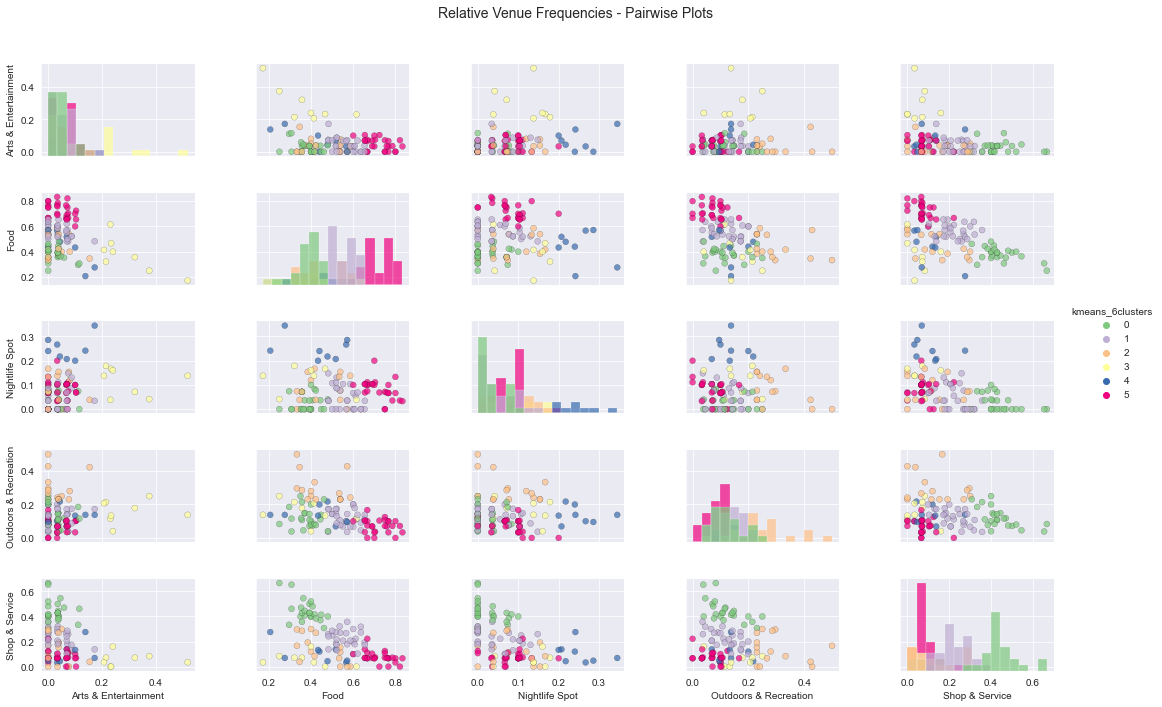

In [53]:
vars_columns = {}
vars_columns['start'] = muc_complete_lab.columns.get_loc('Arts & Entertainment')
vars_columns['end'] = muc_complete_lab.columns.get_loc('Shop & Service') + 1

pairplot_interact = sns.pairplot(data  = muc_complete_lab,
                                 vars = muc_complete_lab.iloc[:,vars_columns['start']:vars_columns['end']],
                                 hue = 'kmeans_6clusters',                                  
                                 palette = 'Accent',
                                 plot_kws=dict(edgecolor = 'black', linewidth = 0.2, alpha = 0.7),
                                 diag_kind = 'hist',
                                 diag_kws=dict(bins = 15, linewidth = 0.2, alpha = 0.7),
                                 height = 2, aspect = 1.5)

fig = pairplot_interact.fig 
fig.subplots_adjust(top = 0.9, hspace = 0.4, wspace = 0.4)
fig.suptitle('Relative Venue Frequencies - Pairwise Plots', fontsize=14);

### Boxplot of relative venue frequencies - by cluster

In [54]:
muc_complete_lab_boxplot = muc_complete_lab.copy(deep = True)
muc_complete_lab_boxplot = pd.melt(muc_complete_lab_boxplot,
                             id_vars = ['Neighborhood', 'kmeans_6clusters'],
                             value_vars = muc_complete_lab_boxplot.iloc[:,1:6],
                             var_name = 'Venue Category',
                             value_name = 'Category Frequency')


In [55]:
muc_complete_lab_boxplot.head()

,Neighborhood,kmeans_6clusters,Venue Category,Category Frequency
0,Alt Moosach,1,Arts & Entertainment,0.035714
1,Altaubing,0,Arts & Entertainment,0.000000
2,Altbogenhausen,1,Arts & Entertainment,0.071429
3,Alte Heide - Hirschau,4,Arts & Entertainment,0.000000
4,Alte Kaserne,5,Arts & Entertainment,0.074074


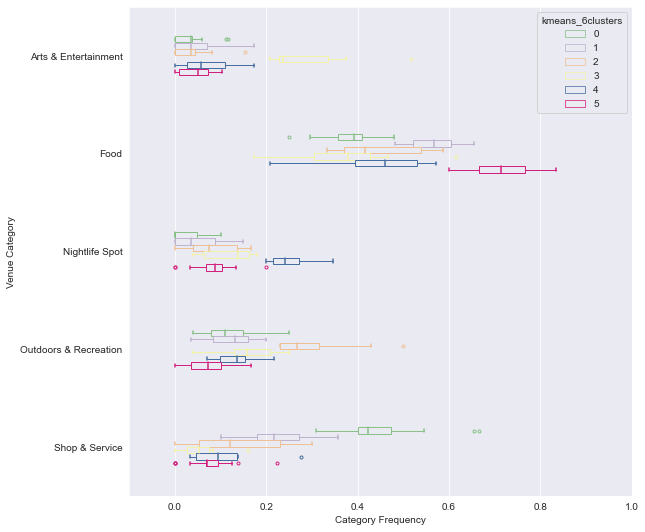

In [56]:
plt.figure(figsize=(9,9))

sns.set_style("darkgrid")

ax = sns.boxplot(data = muc_complete_lab_boxplot,
            y = 'Venue Category',
            x = 'Category Frequency',
            hue = 'kmeans_6clusters',
            palette = 'Accent',
            boxprops = {'linewidth': 1},
            flierprops = {'marker': 'o', 'markerfacecolor': 'none', 'markersize': 3},
            whiskerprops = {'linewidth': 1},
            orient = 'h',
            width = .4)


for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mec(col)

# Also fix the legend
for legpatch in ax.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')                               

ax.set_ylim(4.5, -.5)
ax.set_xlim(-.1,1);